In [3]:
import schemdraw
import schemdraw.elements as elm
import numpy as np

In [2]:
pip install schemdraw

  Using cached schemdraw-0.19-py3-none-any.whl.metadata (2.2 kB)
Using cached schemdraw-0.19-py3-none-any.whl (131 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [356]:
class Circuito:
    def __init__(self):
        self.elements =0 # Variável que conta a quantidade de elementos
        self.elements_list =[] #List that saves the elements
        self.nodes = set()   #Set() faz com que os nós armazenados no conjunto sejam únicos
        self.node_map={}
        self.reference_node=0
        self.currents ={}
        self.vsource_wire={}

    def element(self, Element: str, Start: tuple, End: tuple, Valor: float=0, Label: str = None):
        self.elements_list.append([Element, Start, End, Valor, Label])
        self.elements +=1
        #Adiciona nós aos conjuntos de nós
        self.nodes.add(Start)
        self.nodes.add(End)



    def exibir_elementos(self):
        for i, elemento in enumerate(self.elements_list):
            print(f"Elemento {i+1}: {elemento}")


    def draw(self):
        with schemdraw.Drawing() as d:
            for iten in self.elements_list:
                direction='bot'
                x1,y1 = iten[1]
                x2,y2 = iten[2]
                if(x2==x1):
                    direction='righ'


                if(iten[0]=='Resistor'):
                    #d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( iten[4] +"=" +str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                    #d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                    d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                elif(iten[0]=='Capacitor'):
                    valor_capacitor = f"{int(iten[3].imag)}j" if iten[3].imag % 1 == 0 else f"{iten[3].imag}j"
                    C= d.add(elm.Capacitor().endpoints(iten[1], iten[2]).label(valor_capacitor + " Ω", loc='top').label(iten[4], loc='bot'))
                    #d.add(elm.CurrentLabelInline(direction='Right').at(C).label("i"))
                elif(iten[0]=='Inductor'):
                    d.add(elm.Inductor().endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Voltage Source'):
                    d.add(elm.SourceV().endpoints(iten[1], iten[2]).label(str(iten[3])+"V",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Current Source'):
                    d.add(elm.SourceI().endpoints(iten[1], iten[2]).label(str(iten[3])+"A",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Wire'):
                    d.add(elm.Line().endpoints(iten[1], iten[2]))

    def map_nodes(self):
        #Criar um mapeamento para associar cada nó a um índice
        self.node_map = {}
        #Aqui vamos preencher o dicionário node_map
        # enumerate retorna
        for idx, node in enumerate(self.nodes):
            self.node_map[node] = idx #O nó é a chave do dicionário e o índice o valor
        print("Mapeamento de nós:", self.node_map)


    def montar_equacoes(self):
        n = len(self.nodes)
        G = np.zeros((n, n), dtype=complex) #Matriz condutância
        I = np.zeros(n, dtype=complex) #Matriz de correntes

        for elm in self.elements_list:
          #print(elm)
          Element, Start, End, Valor, Label = elm
          idx_start=self.node_map[Start]
          idx_end=self.node_map[End]

          if(Element=='Current Source'):
            I[idx_start] -= Valor
            I[idx_end] += Valor

          if(Element == 'Voltage Source' ):
            G = np.vstack([G, np.zeros(G.shape[1])])  # Adiciona uma nova linha
            G = np.hstack([G, np.zeros((G.shape[0], 1))])  # Adiciona uma nova coluna
            G[-1, idx_start] = -1
            G[-1, idx_end] = +1
            G[idx_start,-1] =-1
            G[idx_end,-1] =+1
            I = np.append(I, Valor)  # Adiciona o valor da fonte ao vetor de correntes
            self.vsource_wire[Label] = I.shape[0]

          elif(Element == 'Wire'):
            G = np.vstack([G, np.zeros(G.shape[1])])  # Adiciona uma nova linha
            G = np.hstack([G, np.zeros((G.shape[0], 1))])  # Adiciona uma nova coluna
            G[-1, idx_start] = -1
            G[-1, idx_end] = +1
            G[idx_start,-1] =-1
            G[idx_end,-1] =+1
            I = np.append(I, 0)  # Adiciona o valor da fonte ao vetor de correntes
            

          elif(Element == 'Resistor' or Element == 'Inductor' or Element == 'Capacitor' ):
            G[idx_start, idx_start] += 1 / Valor
            G[idx_end, idx_end] += 1 / Valor
            G[idx_start, idx_end] -= 1 / Valor
            G[idx_end, idx_start] -= 1 / Valor

        return G, I

    def resolver_circuito(self):
        G, I = self.montar_equacoes()
        # Escolher um nó de referência, por exemplo, o primeiro nó mapeado
        ref_node = self.reference_node

        # Reduzir a matriz removendo a linha e a coluna do nó de referência
        G_reduced = np.delete(np.delete(G, ref_node, axis=0), ref_node, axis=1)
        I_reduced = np.delete(I, ref_node)

        try:
            # Resolver o sistema reduzido G * V = I
            V_reduced = np.linalg.solve(G_reduced, I_reduced)

            # Reconstruir o vetor completo de tensões
            self.V = np.insert(V_reduced, ref_node, 0)  # Define a tensão do nó de referência como 0
            print("Tensões nos nós:", self.V)
        except np.linalg.LinAlgError as e:
            print("Erro ao resolver o sistema:", e)
            self.V = None
        return self.V

    def set_reference(self,reference: int):
        self.reference_node = reference

    
    def mostrar_matriz_condutancia(self):
        G, I = self.montar_equacoes()
        linhas,colunas = G.shape
        for i in range (linhas):
          for j in range (colunas):
            print("{:.3f}".format(G[i,j]), "|",end=" ")
          print(" ")

    def calcular_correntes(self):
        for elm in self.elements_list:
            Element, Start, End, Valor, Label = elm
            idx_start=self.node_map[Start]
            idx_end=self.node_map[End]
            if Element =='Resistor' or Element =="Capacitor"  or  Element =="Inductor":
                self.currents[Label] = (self.V[idx_start]-self.V[idx_end])/Valor
            elif Element == 'Voltage Source':
                #Retorna o indice na da matriz V que representa 
                indice = self.vsource_wire[Label]
                self.currents[Label] =  self.V[indice-1]
        

    def get_current(self, Label: str):
        self.calcular_correntes()
        #print("Corrente ",self.currents[Label])
        return(self.currents[Label])
        
    def draw_with_currents(self):
        with schemdraw.Drawing() as d:
            for iten in self.elements_list:
                direction_elm='bot'
                x1,y1 = iten[1]
                x2,y2 = iten[2]
                if(x2==x1):
                    direction_elm='bot'


                if(iten[0]=='Resistor'):
                    #d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( iten[4] +"=" +str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                    #d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                    R=d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top'))
                    #d.add(elm.CurrentLabel.at(R).label("{:.2f}".format(self.get_current(iten[4])) ) )
                    d.add(elm.CurrentLabel(length=1,top=False).at(R).label("{:.2f}".format(self.get_current(iten[4]) )  ) )
                elif(iten[0]=='Capacitor'):
                    valor_capacitor = f"{int(iten[3].imag)}j" if iten[3].imag % 1 == 0 else f"{iten[3].imag}j"
                    C= d.add(elm.Capacitor().endpoints(iten[1], iten[2]).label(valor_capacitor + " Ω", loc='top'))
                    #d.add(elm.CurrentLabelInline(direction='Right').at(C).label("i"))
                elif(iten[0]=='Inductor'):
                    d.add(elm.Inductor().endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top'))
                elif(iten[0] == 'Voltage Source'):
                    d.add(elm.SourceV().endpoints(iten[1], iten[2]).label(str(iten[3])+"V",loc='top'))
                elif(iten[0] == 'Current Source'):
                    d.add(elm.SourceI().endpoints(iten[1], iten[2]).label(str(iten[3])+"A",loc='top'))
                elif(iten[0] == 'Wire'):
                    d.add(elm.Line().endpoints(iten[1], iten[2]))




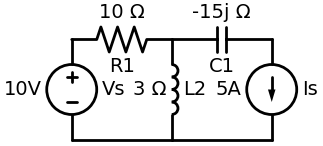

Mapeamento de nós: {(2, -2): 0, (4, 0): 1, (0, 0): 2, (2, 0): 3, (4, -2): 4, (0, -2): 5}
Tensões nos nós: [ 0.         +0.j -9.23076923+75.j 10.         +0.j -9.23076923 +0.j
  0.         +0.j  0.         +0.j -1.92307692 +0.j -5.         +0.j
 -1.92307692 +0.j]


In [358]:
circuito=Circuito()
circuito.element("Voltage Source",(0,-2),(0,0),10,'Vs')
circuito.element('Resistor',(0,0),(2,0),10,"R1")
circuito.element('Capacitor',(2,0),(4,0),-15j,"C1")
circuito.element('Current Source',(4,0),(4,-2),5,'Is')
#circuito.element('Wire',(4,-2),(0,-2))
circuito.element('Wire',(4,-2),(2,-2))
circuito.element('Wire',(2,-2),(0,-2))
#circuito.element('Resistor',(2,0),(0,-2),2)
circuito.element("Inductor",(2,0),(2,-2),3,"L2")
circuito.set_reference(4)
circuito.draw()
circuito.map_nodes()
G,I=circuito.montar_equacoes()
#circuito.mostrar_matriz_condutancia()
V=circuito.resolver_circuito()

In [359]:
circuito.calcular_correntes()
circuito.get_current("Vs")

(-1.923076923076923+0j)

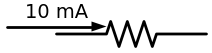

In [360]:
with schemdraw.Drawing() as d:
          #              R=d.add(elm.Resistor().endpoints(iten[1], iten[2]).label( str(iten[3])+" Ω",loc='top'))
                                            #d.add(elm.CurrentLabel.at(R).label("{:.2f}".format(self.get_current(iten[4])) ) )

    R1=d.add(elm.Resistor())
    #R1 = elm.Resistor()
    d.add(elm.CurrentLabel().at((0,0),2,4).label('10 mA'))

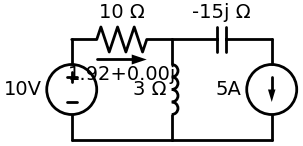

In [361]:
circuito.draw_with_currents()

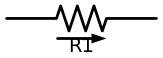

In [349]:
# Criação do desenho
d = schemdraw.Drawing()

# Adiciona um resistor no desenho e salva sua posição
resistor1 = d.add(elm.Resistor().right().label("R1", loc='bottom'))

# Adiciona um CurrentLabel com posição específica e deslocamento
# Aqui, 'xy=resistor1' centraliza a seta sobre o resistor
# dx=0.5 e dy=0.2 deslocam a seta ligeiramente para a direita e para cima do resistor
current_label = d.add(elm.CurrentLabel(length=1,top=False).at(resistor1))

# Desenha o diagrama
d.draw()


In [324]:
import schemdraw
import schemdraw.elements as elm

# Criação do desenho
d = schemdraw.Drawing()

# Adiciona um resistor no desenho e salva sua posição
resistor1 = d.add(elm.Resistor().right().label("R1", loc='bottom'))

# Adiciona um CurrentLabel com parâmetros personalizados
# Definindo dx e dy para ajustar a posição da seta
current_label = d.add(elm.CurrentLabel(
    xy=resistor1,  # Posiciona a seta centralizada no resistor
    dx=0.5,        # Move a seta 0.5 unidade para a direita
    dy=0.2,        # Move a seta 0.2 unidade para cima
    length=2,      # Define o comprimento da seta
    ofst=0.4,      # Distância da seta em relação ao centro do elemento
    top=True,      # Posiciona a seta na parte superior do elemento
    headlength=0.3,  # Define o comprimento da ponta da seta
    headwidth=0.2     # Define a largura da ponta da seta
))

# Desenha o diagrama
d.draw()


TypeError: 'ResistorIEEE' object is not subscriptable